In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Importe de dados

In [109]:
df_animes = pd.read_csv('anime.csv')

## Análise Exploratória de Dados (EDA)

In [3]:
df_animes.head(2)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0


In [6]:
df_animes.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1'],
      dtype='object')

In [7]:
df_animes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17562 entries, 0 to 17561
Data columns (total 35 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MAL_ID         17562 non-null  int64 
 1   Name           17562 non-null  object
 2   Score          17562 non-null  object
 3   Genres         17562 non-null  object
 4   English name   17562 non-null  object
 5   Japanese name  17562 non-null  object
 6   Type           17562 non-null  object
 7   Episodes       17562 non-null  object
 8   Aired          17562 non-null  object
 9   Premiered      17562 non-null  object
 10  Producers      17562 non-null  object
 11  Licensors      17562 non-null  object
 12  Studios        17562 non-null  object
 13  Source         17562 non-null  object
 14  Duration       17562 non-null  object
 15  Rating         17562 non-null  object
 16  Ranked         17562 non-null  object
 17  Popularity     17562 non-null  int64 
 18  Members        17562 non-n

In [110]:
#renomeando as features e transformando tudo em minúsculo para facilitar a utilização
df_animes.rename(columns = {'MAL_ID':'anime_id'}, inplace=True)
df_animes.rename(columns = str.lower, inplace = True)
columns = ['anime_id','name','premiered', 'score','genres','type', 'episodes', 'studios','source','rating','popularity',\
          'members','completed','on-hold','dropped']
df_animes = df_animes[columns]

#separando a feature premiered em season e year e posteriormente dropando ela
df_animes[['season','year']] = df_animes['premiered'].str.split(' ', n=1, expand=True) \
                                .rename(columns={0:'season',1:'year'})
df_animes.drop('premiered', axis=1, inplace=True)

In [16]:
df_animes.head(2)

,anime_id,name,premiered,score,genres,type,episodes,studios,source,rating,popularity,members,completed,on-hold,dropped
0,1,Cowboy Bebop,Spring 1998,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,Sunrise,Original,R - 17+ (violence & profanity),39,1251960,718161,71513,26678
1,5,Cowboy Bebop: Tengoku no Tobira,Unknown,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Movie,1,Bones,Original,R - 17+ (violence & profanity),518,273145,208333,1935,770


In [115]:
for feature in ['type','source','rating','season','year']:
    display(pd.DataFrame(df_animes['anime_id'].groupby(df_animes[feature]).count().sort_values(ascending=False)) \
            .rename(columns={'anime_id':'quantidade'}))

,quantidade
type,
TV,4996
OVA,3894
Movie,3041
Special,2218
ONA,1907
Music,1469
Unknown,37


,quantidade
source,
Original,5215
Manga,3825
Unknown,3567
Visual novel,993
Game,880
Light novel,768
Other,597
Novel,510
Music,317


,quantidade
rating,
PG-13 - Teens 13 or older,6132
G - All Ages,5782
PG - Children,1461
Rx - Hentai,1345
R - 17+ (violence & profanity),1157
R+ - Mild Nudity,997
Unknown,688


,quantidade
season,
Unknown,12817
Spring,1611
Fall,1389
Winter,942
Summer,803


,quantidade
year,
2017,266
2016,262
2018,257
2015,229
2014,227
...,...
1966,11
1963,5
1964,4


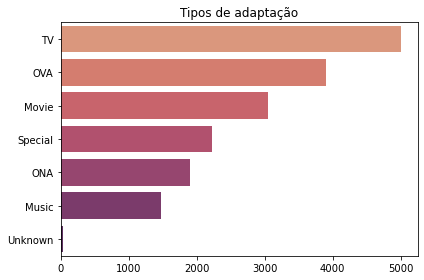

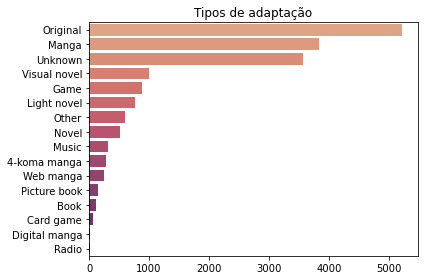

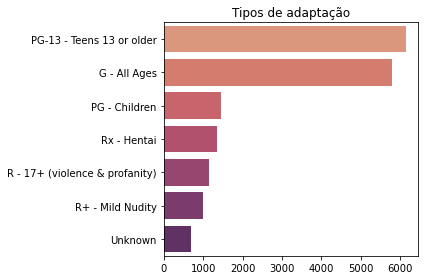

In [103]:
for feature in ['type','source','rating']:
    anime_feature_count = df_animes[feature].value_counts()
    sns.barplot(x=anime_feature_count.values,
                y=anime_feature_count.index,
                palette='flare') \
                .set_title('Tipos de adaptação')
    plt.tight_layout()
    plt.show()

<AxesSubplot:xlabel='year', ylabel='quantidade'>

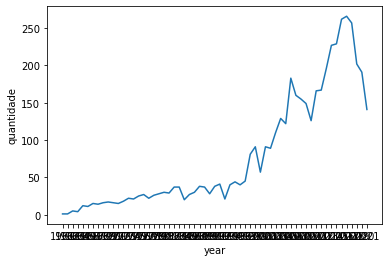

In [162]:
year = pd.DataFrame(df_animes['year'].groupby(df_animes['year']).count()).rename(columns={'year':'quantidade'})
sns.lineplot(data=year,
               x=year.index,
               y=year['quantidade'])